#Importing essential Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
import numpy as np
#Importing some essential Libraries:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

#Loading Data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
load_path_images = '/content/drive/MyDrive/DL/Datasets/images_carvana.npy'
load_path_masks = '/content/drive/MyDrive/DL/Datasets/masks_carvana.npy'
images = np.load(load_path_images)
masks = np.load(load_path_masks)

In [5]:
print("Shapes of images: ", images.shape)
print("Shapes of masks: ", masks.shape)

Shapes of images:  (5088, 220, 220, 3)
Shapes of masks:  (5088, 220, 220)


Visualizing some images:

Image


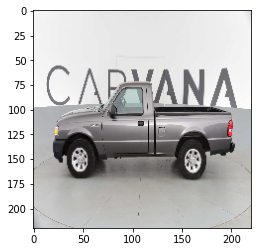

It's Mask


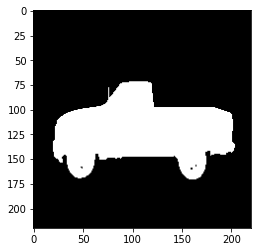

In [6]:
plt.figure(1)
print("Image")
plt.imshow(images[100], cmap= 'gray')
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[100], cmap= 'gray')
plt.show()

In [7]:
#validation dataset
val = images[5050:5080,:,:,:]
val_mask = masks[5050:5080,:,:]

In [8]:
#Train Dataset
images = images[0:5050]
masks = masks[0:5050]

In [9]:
images.shape

(5050, 220, 220, 3)

In [10]:
val.shape

(30, 220, 220, 3)

Checking if GPU is available

In [11]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transferring the Images to GPU

In [12]:
images = torch.tensor(images, device = DEVICE)
masks = torch.tensor(masks, device = DEVICE)

Normalize the image

In [13]:
images = images.float()
mean = (torch.mean(images))
images = images/ mean

In [14]:
val = torch.tensor(val, device = DEVICE)
val_mask = torch.tensor(val_mask, device = DEVICE)
val = val.float()
val = val/ mean


Reshaping the Image for network to work on

In [15]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

In [16]:
val = val.permute(0,3,1,2)

In [17]:
import torchvision.transforms.functional as TF

#Creating Unet Netowk architecture

##Paper: https://arxiv.org/abs/1505.04597
There is some changes as compared to orignal Unet architectures to improve the performance

In [18]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels):     #Features is the dimension of Height and Width of the image
    super(unet, self).__init__()
    self.conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv1_2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv1_3 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv1_4 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv2_1 = nn.Sequential(
            nn.Conv2d(128, 64, 1, 1, 0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv2_2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv2_3 = nn.Sequential(
            nn.Conv2d(128, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv2_4 = nn.Sequential(
            nn.Conv2d(128, 64, 1, 1, 0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Sequential(
            nn.Conv2d(256, 128, 1, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.conv3_2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.conv3_3 = nn.Sequential(
            nn.Conv2d(256, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.conv3_4 = nn.Sequential(
            nn.Conv2d(256, 128, 1, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Sequential(
            nn.Conv2d(512, 256, 1, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.conv4_2 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.conv4_3 = nn.Sequential(
            nn.Conv2d(512, 256, 5, 1, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 5, 1, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.conv4_4 = nn.Sequential(
            nn.Conv2d(512, 256, 1, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Sequential(
            nn.Conv2d(1024, 512, 1, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.conv5_2 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.conv5_3 = nn.Sequential(
            nn.Conv2d(1024, 512, 5, 1, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 5, 1, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.conv5_4 = nn.Sequential(
            nn.Conv2d(1024, 512, 1, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

    #upsampling layers
    self.up1 = nn.ConvTranspose2d( 2048, 1024, kernel_size=2, stride=2, )
    self.conv6_1 = nn.Sequential(
            nn.Conv2d(2048, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv6_2 = nn.Sequential(
            nn.Conv2d(2048, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv6_3 = nn.Sequential(
            nn.Conv2d(2048, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv6_4 = nn.Sequential(
            nn.Conv2d(2048, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    
    self.up2 = nn.ConvTranspose2d( 128, 512, kernel_size=2, stride=2, )
    self.conv7_1 = nn.Sequential(
            nn.Conv2d(1024, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv7_2 = nn.Sequential(
            nn.Conv2d(1024, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv7_3 = nn.Sequential(
            nn.Conv2d(1024, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv7_4 = nn.Sequential(
            nn.Conv2d(1024, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    
    self.up3 = nn.ConvTranspose2d( 128, 256, kernel_size=2, stride=2, )
    self.conv8_1 = nn.Sequential(
            nn.Conv2d(512, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv8_2 = nn.Sequential(
            nn.Conv2d(512, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv8_3 = nn.Sequential(
            nn.Conv2d(512, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    self.conv8_4 = nn.Sequential(
            nn.Conv2d(512, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
    
    self.up4 = nn.ConvTranspose2d( 128, 128, kernel_size=2, stride=2, )

    self.conv9_1 = nn.Sequential(
            nn.Conv2d(256, 32, 1, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
    self.conv9_2 = nn.Sequential(
            nn.Conv2d(256, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
    self.conv9_3 = nn.Sequential(
            nn.Conv2d(256, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, 5, 1, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
    self.conv9_4 = nn.Sequential(
            nn.Conv2d(256, 16, 1, 1, 0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
    
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)
    
  def forward(self, input):

    #Downsampling Part
    out1_1 = self.conv1_1(input)   #These are added inception blocks:
    out1_2 = self.conv1_2(input)
    out1_3 = self.conv1_3(input)
    out1_4 = self.conv1_4(input)
    
    out =  torch.cat((out1_1, out1_2, out1_3, out1_4), dim = 1)

    out_1 = out
    out = self.pool1(out)       #()

    out2_1 = self.conv2_1(out)
    out2_2 = self.conv2_2(out)
    out2_3 = self.conv2_3(out)
    out2_4 = self.conv2_4(out)
    out = torch.cat((out2_1, out2_2, out2_3, out2_4), dim = 1)

    out_2 = out
    out = self.pool2(out)

    out3_1 = self.conv3_1(out)
    out3_2 = self.conv3_2(out)
    out3_3 = self.conv3_3(out)
    out3_4 = self.conv3_4(out)
    out = torch.cat((out3_1, out3_2, out3_3, out3_4), dim = 1)

    out_3 = out
    out = self.pool3(out)
    
    out4_1 = self.conv4_1(out)
    out4_2 = self.conv4_2(out)
    out4_3 = self.conv4_3(out)
    out4_4 = self.conv4_4(out)
    out = torch.cat((out4_1, out4_2, out4_3, out4_4), dim = 1)

    out_4 = out
    out = self.pool4(out)
    
    out5_1 = self.conv5_1(out)
    out5_2 = self.conv5_2(out)
    out5_3 = self.conv5_3(out)
    out5_4 = self.conv5_4(out)
    out = torch.cat((out5_1, out5_2, out5_3, out5_4), dim = 1)
    
    
    #Upsampling part
    out = self.up1(out) 
    if out_4.shape != out.shape:
      out = TF.resize(out, size= [out_4.shape[2], out_4.shape[3]])
    out = torch.cat((out_4, out), dim = 1)
    out6_1 = self.conv6_1(out)
    out6_2 = self.conv6_2(out)
    out6_3 = self.conv6_3(out)
    out6_4 = self.conv6_4(out)
    out = torch.cat((out6_1, out6_2, out6_3, out6_4), dim = 1)

    
    out = self.up2(out)  
    if out_3.shape != out.shape:
      out = TF.resize(out, size= [out_3.shape[2], out_3.shape[3]]) 
    out = torch.cat((out_3, out), dim = 1)
    out7_1 = self.conv7_1(out)
    out7_2 = self.conv7_2(out)
    out7_3 = self.conv7_3(out)
    out7_4 = self.conv7_4(out)
    out = torch.cat((out7_1, out7_2, out7_3, out7_4), dim = 1)

    out = self.up3(out) 
    if out_2.shape != out.shape:
      out = TF.resize(out, size= [out_2.shape[2], out_2.shape[3]])    
    out = torch.cat((out_2, out), dim = 1)
    out8_1 = self.conv8_1(out)
    out8_2 = self.conv8_2(out)
    out8_3 = self.conv8_3(out)
    out8_4 = self.conv8_4(out)
    out = torch.cat((out8_1, out8_2, out8_3, out8_4), dim = 1)
    
    out = self.up4(out) 
    if out_1.shape != out.shape:
      out = TF.resize(out, size= [out_1.shape[2], out_1.shape[3]])    
    out = torch.cat((out_1, out), dim = 1)
    out9_1 = self.conv9_1(out)
    out9_2 = self.conv9_2(out)
    out9_3 = self.conv9_3(out)
    out9_4 = self.conv9_4(out)
    out = torch.cat((out9_1, out9_2, out9_3, out9_4), dim = 1)
    
    out = self.conv_final(out)

    return out

    #Using transpose convolutions insted of Bilinear interpolation used in orignal paper




In [19]:
model = unet(3,2).to(device = DEVICE)

In [20]:
model(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2])).shape

torch.Size([1, 2, 220, 220])

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.5)   #Every 100 epochs our learning rate will be multiplied by gamma

#Training the model using pytorch dataloader and other pytorch tools

In [22]:
from torch.utils.data import Dataset, DataLoader     #Importing Dataloader

In [23]:
class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding masks
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [24]:
data = CustomImageDataset(images, masks)  #data is the object for the class that takes index and gives data and it's mask

In [25]:
batchsize = 14
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [26]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.3 MB/s 


In [27]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2).to(DEVICE)

##Training Network

In [28]:
#Model Training
loss_graph = []
num_epochs = 10   #Here each epoch means that at each epoch the model will train once over the entire datset using sgd on small batches


for j in range(num_epochs):

  with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Jaccard index before epoch ", j, " is: ", jaccard(pred, val_mask).cpu().item())

  model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):

    optimizer.zero_grad()
    y_pred = model(x_batch)
    y_pred = y_pred.permute(0,2,3,1)
    y_pred = y_pred.reshape(-1,2)
    y_batch = y_batch.reshape(-1)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())

    #schedular step
    #step_lr.step()

  print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())
  #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Jaccard index before epoch  0  is:  0.3789263069629669
Epoch:  1 , loss is:  0.012906617484986782
Jaccard index before epoch  1  is:  0.9861490726470947
Epoch:  2 , loss is:  0.010716060176491737
Jaccard index before epoch  2  is:  0.9898017048835754
Epoch:  3 , loss is:  0.008374265395104885
Jaccard index before epoch  3  is:  0.9919090270996094
Epoch:  4 , loss is:  0.009547950699925423
Jaccard index before epoch  4  is:  0.991100013256073
Epoch:  5 , loss is:  0.007164316717535257
Jaccard index before epoch  5  is:  0.992603063583374
Epoch:  6 , loss is:  0.006855539977550507
Jaccard index before epoch  6  is:  0.992969274520874
Epoch:  7 , loss is:  0.006519819609820843
Jaccard index before epoch  7  is:  0.9923492670059204
Epoch:  8 , loss is:  0.006984890904277563
Jaccard index before epoch  8  is:  0.9929275512695312
Epoch:  9 , loss is:  0.005072564817965031
Jaccard index before epoch  9  is:  0.9932378530502319
Epoch:  10 , loss is:  0.00465961592271924


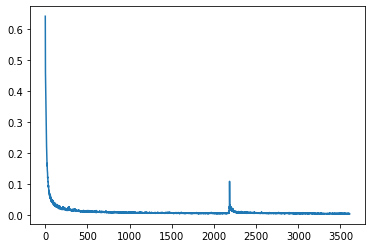

In [29]:
#Loss Graph
plt.plot(loss_graph)  
plt.show()

#Final result from the Trained Model: 

Prediction on seen data (Training data)

Predicted segmentation mask


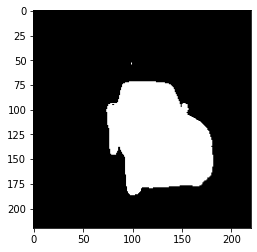

Actual mask


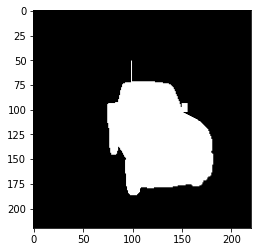

In [31]:
model.eval()
y = model(images[111].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(220,220)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[111].clone().cpu()), cmap= 'gray')
plt.show()

Prediction on unseen data (Validation data)

Predicted segmentation mask


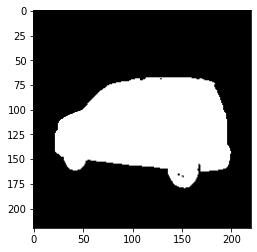

Actual mask


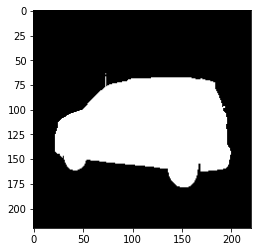

In [32]:
model.eval()
y = model(val[11].reshape(1,val.shape[1], val.shape[2], val.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(220,220)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(val_mask[11].clone().cpu()), cmap= 'gray')
plt.show()